## import packages

In [1]:
import numpy as np
import tensorflow as tf


## importing data

In [2]:
train=np.load('train.npz')
test=np.load('test.npz')
val=np.load('valid.npz')


In [3]:
train_sentence1=train['ques1']
train_sentence2=train['ques2']
train_label=train['label']
train_label=np.reshape(train_label,[-1,1])


In [4]:
test_sentence1=test['ques1']
test_sentence2=test['ques2']
test_label=test['label']
test_label=np.reshape(test_label,[-1,1])

In [5]:
val_sentence1=val['ques1']
val_sentence2=val['ques2']
val_label=val['label']
val_label=np.reshape(val_label,[-1,1])

In [6]:
len(train_label),len(test_label),len(val_label)

(209991, 89895, 99)

## creating word embedding

In [7]:
vec=np.load('embed.npz')


In [8]:
vec_x=vec['embed']

## initializing parameters

In [9]:
input_size=200
hidden_layer=50
train_size=100
max_length=237
valid_size=99
test_size=100
lr=0.0005

In [10]:
wi = tf.get_variable('weigths_in', shape=[input_size,hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))
wf = tf.get_variable('weigths_forget', shape=[input_size,hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))
wc = tf.get_variable('weigths_memory', shape=[input_size,hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))
wo = tf.get_variable('weigths_out', shape=[input_size,hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))

In [11]:
ui = tf.get_variable('weigths_hidden_in', shape=[hidden_layer, hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))
uf = tf.get_variable('weigths_hidden_forget', shape=[hidden_layer, hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))
uc = tf.get_variable('weigths_hidden_memory', shape=[hidden_layer, hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))
uo = tf.get_variable('weigths_hidden_out', shape=[hidden_layer, hidden_layer],
                initializer=tf.random_normal_initializer(0,0.25))

## model to be trained

In [12]:
#siamese network
def train():
    
    # variables
    
    loss_train,loss_val,iterr=[],[],[]
    x1=tf.placeholder(shape=[None,max_length],dtype=tf.int32)
    x2=tf.placeholder(shape=[None,max_length],dtype=tf.int32)
    y=tf.placeholder(shape=[None,None],dtype=tf.float32)
    
    
    hprev=tf.placeholder(shape=[None,hidden_layer],dtype=tf.float32)
    cprev=tf.placeholder(shape=[None,hidden_layer],dtype=tf.float32)
       
    con=[hprev,cprev]
    
    #embedding lookup 
    X1_embed=tf.nn.embedding_lookup(vec_x,x1)
    X2_embed=tf.nn.embedding_lookup(vec_x,x2)
    X1_embed = tf.transpose(X1_embed, [1, 0, 2])
    X2_embed = tf.transpose(X2_embed, [1, 0, 2])
        
    #lstm  cell
    h1=tf.scan(LSTM,X1_embed,initializer=con)
    h1=h1[0]
    h2=tf.scan(LSTM,X2_embed,initializer=con)
    h2=h2[0]
    
    #taking last hidden for each word of a sequence
    h1_t=h1[-1]
    h2_t=h2[-1]
    
    #distance between both sequence
    preds_out=tf.abs(h1_t-h2_t)
  
    preds=tf.reduce_sum(preds_out,axis=1)
    
    preds=tf.nn.sigmoid(preds)
   
    preds=1-preds
    
    preds=tf.reshape(preds,[-1,1]) 
    y=tf.reshape(y,[-1,1]) 
    
    #loss as mean square error
    loss=tf.reduce_mean(tf.losses.mean_squared_error(predictions=preds,labels=y))
    
    #optimizer as AdamOptimizer
    optimizer=tf.train.AdamOptimizer(0.0005).minimize(loss)
       
    
    with tf.Session() as session:
        
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())
        d=0    
       
        #stochastic gradient descent of mini batch of 100 at each iteration
        for epoch in range(1801):
                
            train_x1,train_x2,train_y=get_batch(train_sentence1,train_sentence2, train_label, train_size, random=False,start=d,end=d+train_size)
           
            #feeding train set
            l,o,w=session.run([loss,optimizer,wi],feed_dict={x1:train_x1,x2:train_x2,y:train_y,hprev:np.zeros((train_size,hidden_layer)),cprev:np.zeros((train_size,hidden_layer))})
            
            if epoch%100==0:
                    iterr.append(epoch)
                    print "loss for iteration no:",epoch
                    print "training set",l
                    loss_train.append(l)
                   
                    #feeding validation set
                    l1=session.run([loss],feed_dict={x1:val_sentence1,x2:val_sentence2,y:val_label,hprev: np.zeros((valid_size, hidden_layer)),
                cprev:np.zeros((valid_size,hidden_layer))})
                    
                    loss_val.append(l1)
                    print "validations set",l1
                    print "\n"
                        

            d=d+train_size-1    
            
        print "------Training over----"
        print"\n"
       
    
    
        c=0
        loss_test=[]
        for j in range(800):
            
            
            test_x1,test_x2,test_y=get_batch(test_sentence1,test_sentence2, test_label, train_size, random=False,start=c,end=c+train_size)
           
            #feeding test set
            lt=session.run([loss],feed_dict={x1:test_x1,x2:test_x2,y:test_y,hprev:np.zeros((train_size,hidden_layer)),cprev:np.zeros((train_size,hidden_layer))})
            c=c+train_size-1
            loss_test.append(lt)
            
        print "testing over"
        
        return loss_test,loss_train,loss_val,iterr

## using Long Short Term Memory cell

In [13]:

def LSTM(con,x_t):
    
    x_t=tf.reshape(x_t,[-1,input_size])
    x_t=tf.cast(x_t,dtype=tf.float32)
   
    hprev = tf.reshape(con[0], [-1, hidden_layer])
    cprev = tf.reshape(con[1], [-1, hidden_layer])
    
    i_t=tf.sigmoid(tf.matmul(x_t,wi) + tf.matmul(hprev,ui))
    
    f_t=tf.sigmoid(tf.matmul(x_t,wf) + tf.matmul(hprev,uf))
    
    c=tf.tanh(tf.matmul(x_t,wc) + tf.matmul(hprev,uc))
    
    c_t=tf.multiply(i_t,c)+tf.multiply(f_t,cprev)
    
    o_t=tf.sigmoid(tf.matmul(x_t,wo) +  tf.matmul(hprev,uo))
    
    h_t=tf.multiply(o_t,tf.tanh(c_t))
   
    return([h_t,c_t])

## extracting batches of data

In [14]:
def get_batch(x11,x12, y1, train_size, random=False, start=0, end=0):
    if random:
        idx = np.random.choice(range(len(x11)), size=train_size, replace=False)
    else:
        idx = np.arange(start, end)
    return x11[idx],x12[idx], y1[idx]

## executing training

In [15]:
test_list,train_list,val_list,iteration=train()

loss for iteration no: 0
training set 0.25
validations set [0.24999942]


loss for iteration no: 100
training set 0.222384
validations set [0.23335259]


loss for iteration no: 200
training set 0.21204
validations set [0.21794483]


loss for iteration no: 300
training set 0.236924
validations set [0.22560434]


loss for iteration no: 400
training set 0.217261
validations set [0.23057801]


loss for iteration no: 500
training set 0.220633
validations set [0.21703728]


loss for iteration no: 600
training set 0.242947
validations set [0.22723515]


loss for iteration no: 700
training set 0.196413
validations set [0.21665776]


loss for iteration no: 800
training set 0.221824
validations set [0.2164052]


loss for iteration no: 900
training set 0.237786
validations set [0.21633676]


loss for iteration no: 1000
training set 0.227188
validations set [0.25061986]


loss for iteration no: 1100
training set 0.193618
validations set [0.21093272]


loss for iteration no: 1200
training set 0.212

## Results

## plotting graph for los of validation and training set

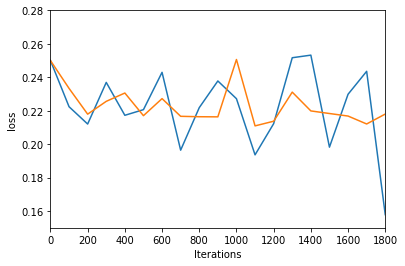

In [16]:

import  matplotlib.pyplot as plt
%matplotlib inline
plt.plot(iteration,train_list)
plt.plot(iteration,val_list)
plt.axis([0, 1800, 0.15, 0.28])
plt.ylabel('loss')
plt.xlabel('Iterations')
plt.show()


## plot for loss of validation set at each iteration

[0, 1800, 0.18, 0.26]

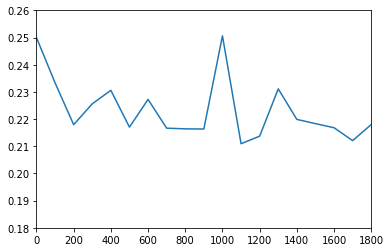

In [17]:
plt.plot(iteration,val_list)
plt.axis([0, 1801, 0.18, 0.26])

## plot for loss of training set at each iteration

[-1, 1800, 0.18, 0.26]

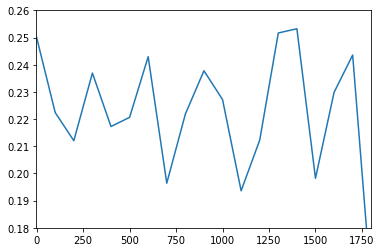

In [18]:
plt.plot(iteration,train_list)
plt.axis([-1, 1801, 0.18, 0.26])

## evaluating the performance by calcualting average loss on test set

In [19]:
s=0
for i in range(len(test_list)):
    s=s+test_list[i][0]
loss_test=s/800.0
print "total avg loss for test set",loss_test

total avg loss for test set 0.207000501584
